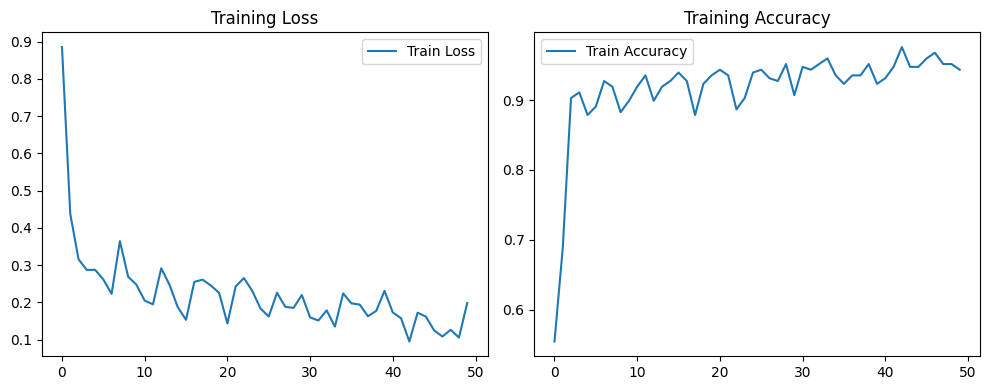


Classification Report:
               precision    recall  f1-score   support

         PR−       0.88      1.00      0.93        70
         PR+       1.00      0.91      0.95       114

    accuracy                           0.95       184
   macro avg       0.94      0.96      0.94       184
weighted avg       0.95      0.95      0.95       184



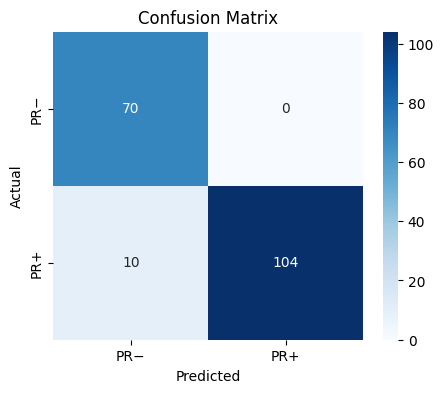

In [12]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# DATASET SETUP
# ----------------------------
positive_dir = "/kaggle/input/pr-positive-ihc/PR+"
negative_dir = "/kaggle/input/pr-negative-ihc/PR-"
working_dir = "/kaggle/working/PR_data"

# Create train/test directories
for split in ['train', 'test']:
    for cls in ['positive', 'negative']:
        os.makedirs(os.path.join(working_dir, split, cls), exist_ok=True)

# Gather image paths
pos_images = glob(os.path.join(positive_dir, "*.png")) + glob(os.path.join(positive_dir, "*.jpg"))
neg_images = glob(os.path.join(negative_dir, "*.png")) + glob(os.path.join(negative_dir, "*.jpg"))

all_images = [(img, "positive") for img in pos_images] + [(img, "negative") for img in neg_images]
random.shuffle(all_images)

# Perform 70/30 train-test split
train_imgs, test_imgs = train_test_split(
    all_images, test_size=0.3, stratify=[label for _, label in all_images], random_state=42
)

# Copy files into new directories
def copy_images(image_list, dest_dir):
    for src, label in image_list:
        dest_path = os.path.join(working_dir, dest_dir, label, os.path.basename(src))
        shutil.copy(src, dest_path)

copy_images(train_imgs, 'train')
copy_images(test_imgs, 'test')

# ----------------------------
# DATA TRANSFORMS AND LOADERS
# ----------------------------
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_ds = ImageFolder(os.path.join(working_dir, 'train'), transform=train_transform)
test_ds = ImageFolder(os.path.join(working_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# ----------------------------
# SIMPLE CNN MODEL
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# TRAINING LOOP (NO VALIDATION)
# ----------------------------
train_loss, train_acc = [], []

for epoch in range(50):
    model.train()
    running_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / len(train_ds))

# ----------------------------
# PLOTS
# ----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.title("Training Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# TEST EVALUATION
# ----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["PR−", "PR+"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["PR−", "PR+"], yticklabels=["PR−", "PR+"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


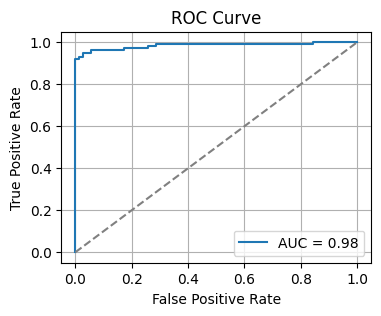

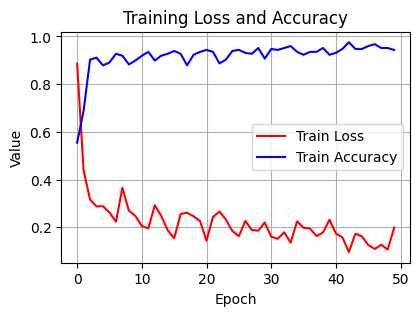

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

# AUC-ROC calculation
y_scores = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for PR+
        y_scores.extend(probs.cpu().numpy())

auc_score = roc_auc_score(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot AUC-ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Combined plot for loss and accuracy
plt.figure(figsize=(4.5, 3))
plt.plot(train_loss, label='Train Loss', color='red')
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Accuracy")
plt.legend()
plt.grid()
plt.show()


In [18]:
import torch.nn.functional as F

# ----------------------------
# CONDITIONAL GAN (MedSynGAN) ARCHITECTURE
# ----------------------------

# Number of image channels and label classes
image_size = 128
nz = 100  # noise dimension
nc = 3    # number of image channels (RGB)
num_classes = 2
embedding_dim = 100

# ----------------------------
# Generator
# ----------------------------
class MedSynGenerator(nn.Module):
    def __init__(self):
        super(MedSynGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(nz + embedding_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, nc, kernel_size=4, stride=4, padding=0),    # 128x128
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        return self.model(x)

# ----------------------------
# Discriminator
# ----------------------------
class MedSynDiscriminator(nn.Module):
    def __init__(self):
        super(MedSynDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)

        self.model = nn.Sequential(
            nn.Conv2d(nc + 1, 64, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),      # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),     # 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_img = self.label_emb(labels).view(labels.size(0), 1, image_size, image_size)
        x = torch.cat((img, label_img), dim=1)
        return self.model(x)

# Initialize models
netG = MedSynGenerator().to(device)
netD = MedSynDiscriminator().to(device)

# Optimizers and Loss
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Set for next step
{
    "MedSynGAN_Generator": netG.__class__.__name__,
    "MedSynGAN_Discriminator": netD.__class__.__name__,
    "Noise_Dimension": nz,
    "Image_Size": image_size,
    "Classes": ["PR-", "PR+"]
}


{'MedSynGAN_Generator': 'MedSynGenerator',
 'MedSynGAN_Discriminator': 'MedSynDiscriminator',
 'Noise_Dimension': 100,
 'Image_Size': 128,
 'Classes': ['PR-', 'PR+']}

[Epoch 1/50] Loss_D: 0.0381 Loss_G: 5.3817
[Epoch 2/50] Loss_D: 0.0414 Loss_G: 4.8920
[Epoch 3/50] Loss_D: 0.0227 Loss_G: 5.0616
[Epoch 4/50] Loss_D: 0.0513 Loss_G: 8.5215
[Epoch 5/50] Loss_D: 0.0572 Loss_G: 9.7769
[Epoch 6/50] Loss_D: 0.6503 Loss_G: 15.3283
[Epoch 7/50] Loss_D: 0.0938 Loss_G: 3.6636
[Epoch 8/50] Loss_D: 0.2299 Loss_G: 9.2777
[Epoch 9/50] Loss_D: 0.1871 Loss_G: 3.7615
[Epoch 10/50] Loss_D: 0.1544 Loss_G: 3.0385


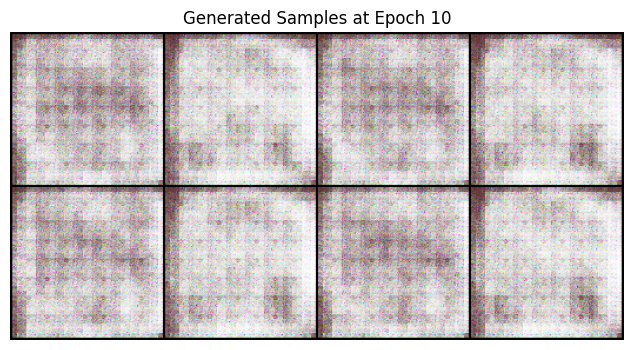

[Epoch 11/50] Loss_D: 0.7673 Loss_G: 2.9990
[Epoch 12/50] Loss_D: 0.1409 Loss_G: 6.7708
[Epoch 13/50] Loss_D: 1.2955 Loss_G: 11.5774
[Epoch 14/50] Loss_D: 1.6364 Loss_G: 1.4543
[Epoch 15/50] Loss_D: 1.5168 Loss_G: 10.6713
[Epoch 16/50] Loss_D: 0.0673 Loss_G: 4.9477
[Epoch 17/50] Loss_D: 0.2602 Loss_G: 9.5873
[Epoch 18/50] Loss_D: 0.3938 Loss_G: 5.2747
[Epoch 19/50] Loss_D: 2.3777 Loss_G: 1.5400
[Epoch 20/50] Loss_D: 2.3831 Loss_G: 9.2530


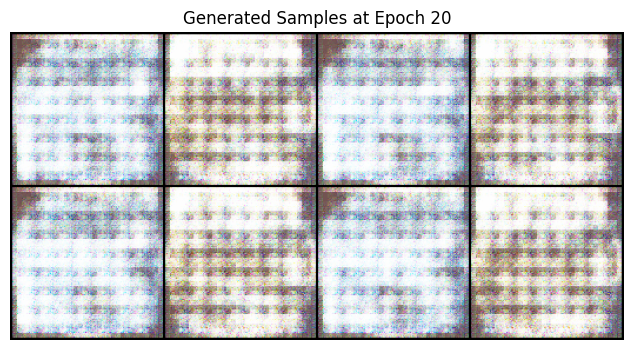

[Epoch 21/50] Loss_D: 0.6888 Loss_G: 2.4119
[Epoch 22/50] Loss_D: 1.0523 Loss_G: 6.7294
[Epoch 23/50] Loss_D: 3.1345 Loss_G: 0.2591
[Epoch 24/50] Loss_D: 0.5393 Loss_G: 8.0146
[Epoch 25/50] Loss_D: 0.6059 Loss_G: 5.9081
[Epoch 26/50] Loss_D: 0.4043 Loss_G: 4.3544
[Epoch 27/50] Loss_D: 1.1010 Loss_G: 2.9028
[Epoch 28/50] Loss_D: 0.1887 Loss_G: 3.9479
[Epoch 29/50] Loss_D: 0.3717 Loss_G: 2.5776
[Epoch 30/50] Loss_D: 0.2501 Loss_G: 5.1541


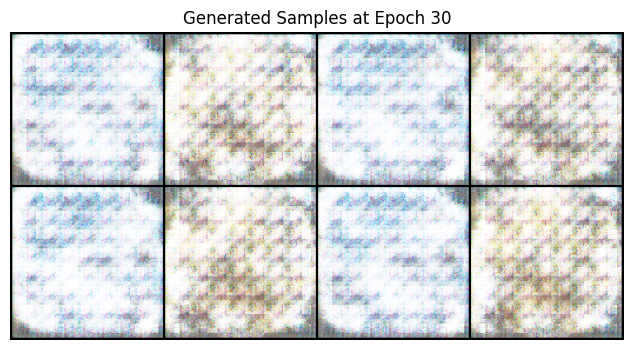

[Epoch 31/50] Loss_D: 1.2269 Loss_G: 10.5137
[Epoch 32/50] Loss_D: 2.5020 Loss_G: 9.3374
[Epoch 33/50] Loss_D: 1.6161 Loss_G: 0.8888
[Epoch 34/50] Loss_D: 1.0049 Loss_G: 5.4575
[Epoch 35/50] Loss_D: 0.2689 Loss_G: 1.7004
[Epoch 36/50] Loss_D: 1.2972 Loss_G: 3.6924
[Epoch 37/50] Loss_D: 1.5267 Loss_G: 2.1540
[Epoch 38/50] Loss_D: 0.4141 Loss_G: 3.0967
[Epoch 39/50] Loss_D: 0.7530 Loss_G: 2.0356
[Epoch 40/50] Loss_D: 0.2792 Loss_G: 3.0302


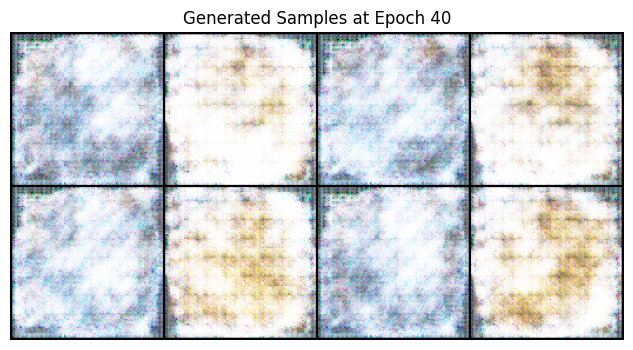

[Epoch 41/50] Loss_D: 0.2577 Loss_G: 6.3842
[Epoch 42/50] Loss_D: 0.1847 Loss_G: 4.2638
[Epoch 43/50] Loss_D: 0.8897 Loss_G: 4.0931
[Epoch 44/50] Loss_D: 0.0913 Loss_G: 4.6389
[Epoch 45/50] Loss_D: 1.9424 Loss_G: 1.9020
[Epoch 46/50] Loss_D: 0.7369 Loss_G: 8.5263
[Epoch 47/50] Loss_D: 0.9126 Loss_G: 3.6051
[Epoch 48/50] Loss_D: 1.2353 Loss_G: 2.2317
[Epoch 49/50] Loss_D: 0.4667 Loss_G: 4.0540
[Epoch 50/50] Loss_D: 0.3350 Loss_G: 2.0933


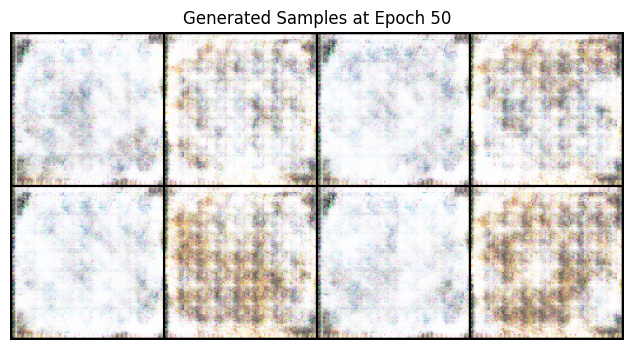

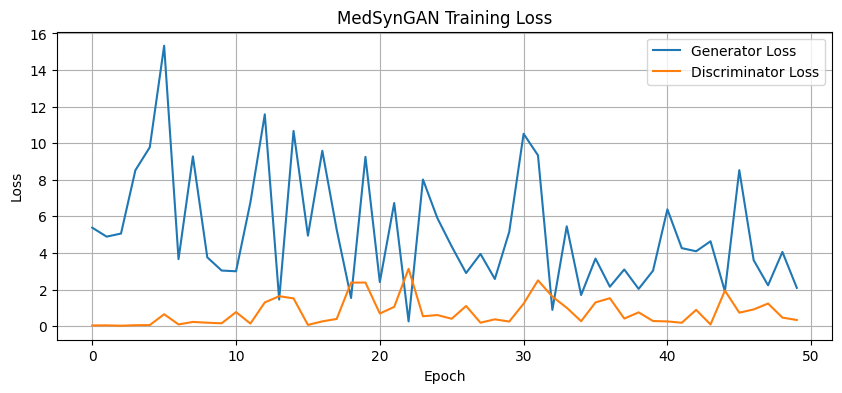

In [19]:
import torchvision.utils as vutils

# ----------------------------
# GAN TRAINING LOOP
# ----------------------------

num_epochs = 50
fixed_noise = torch.randn(8, nz, device=device)
fixed_labels = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1], dtype=torch.long, device=device)

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for real_imgs, labels in train_loader:
        batch_size = real_imgs.size(0)
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        real = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        netD.zero_grad()
        output_real = netD(real_imgs, labels)
        loss_real = criterion(output_real, real)

        noise = torch.randn(batch_size, nz, device=device)
        fake_imgs = netG(noise, labels)
        output_fake = netD(fake_imgs.detach(), labels)
        loss_fake = criterion(output_fake, fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        loss_G = criterion(output, real)  # Fool the discriminator
        loss_G.backward()
        optimizerG.step()

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    # Show sample generations every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_sample = netG(fixed_noise, fixed_labels).detach().cpu()
            grid = vutils.make_grid(fake_sample, nrow=4, normalize=True)
            plt.figure(figsize=(8, 4))
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Generated Samples at Epoch {epoch+1}")
            plt.axis("off")
            plt.show()

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MedSynGAN Training Loss")
plt.legend()
plt.grid()
plt.show()


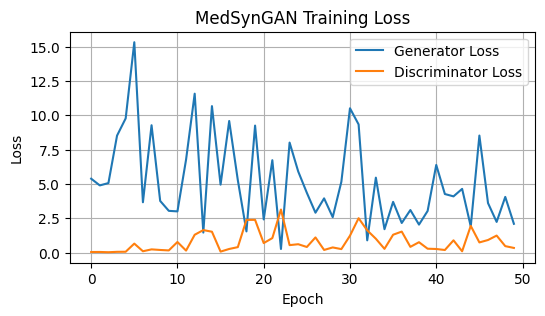

In [21]:
# Plot loss curves
plt.figure(figsize=(6, 3))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MedSynGAN Training Loss")
plt.legend()
plt.grid()
plt.show()

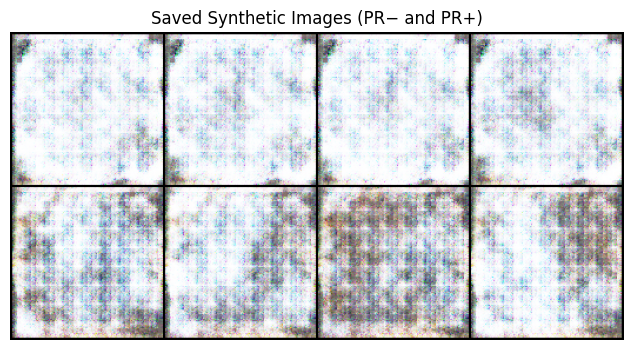

{'synthetic_positive': 200, 'synthetic_negative': 200, 'total_synthetic': 400}

In [22]:
import torchvision.transforms.functional as TF
from torchvision.utils import save_image

# ----------------------------
# GENERATE & SAVE SYNTHETIC IMAGES
# ----------------------------

synthetic_dir = "/kaggle/working/synthetic/train"
os.makedirs(os.path.join(synthetic_dir, "positive"), exist_ok=True)
os.makedirs(os.path.join(synthetic_dir, "negative"), exist_ok=True)

def generate_and_save_images(generator, label, count, save_path):
    generator.eval()
    label_tensor = torch.full((count,), label, dtype=torch.long, device=device)
    batch_size = 20  # generate in small batches
    for i in range(0, count, batch_size):
        batch_labels = label_tensor[i:i+batch_size]
        noise = torch.randn(batch_labels.size(0), nz, device=device)
        with torch.no_grad():
            fake_images = generator(noise, batch_labels)
        for j, img in enumerate(fake_images):
            img_path = os.path.join(save_path, f"synthetic_{label}_{i+j}.png")
            save_image(img, img_path, normalize=True)

# Generate 200 synthetic images per class
generate_and_save_images(netG, label=0, count=200, save_path=os.path.join(synthetic_dir, "negative"))
generate_and_save_images(netG, label=1, count=200, save_path=os.path.join(synthetic_dir, "positive"))

# Sample visualization
sample_imgs = []
sample_labels = []

for label_str in ["negative", "positive"]:
    folder = os.path.join(synthetic_dir, label_str)
    sample_files = sorted(os.listdir(folder))[:4]
    for file in sample_files:
        img = Image.open(os.path.join(folder, file))
        sample_imgs.append(TF.to_tensor(img))
        sample_labels.append(label_str)

# Show a few saved synthetic images
grid = make_grid(sample_imgs, nrow=4, normalize=True)
plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Saved Synthetic Images (PR− and PR+)")
plt.axis("off")
plt.show()

# Confirm counts
{
    "synthetic_positive": len(os.listdir(os.path.join(synthetic_dir, "positive"))),
    "synthetic_negative": len(os.listdir(os.path.join(synthetic_dir, "negative"))),
    "total_synthetic": len(os.listdir(os.path.join(synthetic_dir, "positive"))) +
                       len(os.listdir(os.path.join(synthetic_dir, "negative")))
}


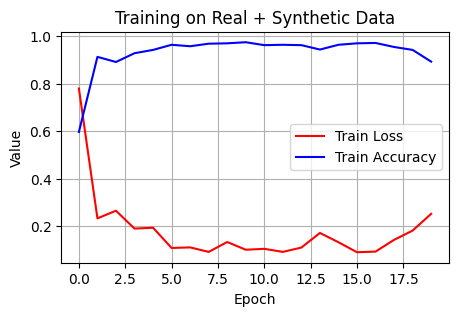


Classification Report (Augmented):
               precision    recall  f1-score   support

         PR−       0.91      0.96      0.93        70
         PR+       0.97      0.94      0.96       114

    accuracy                           0.95       184
   macro avg       0.94      0.95      0.94       184
weighted avg       0.95      0.95      0.95       184



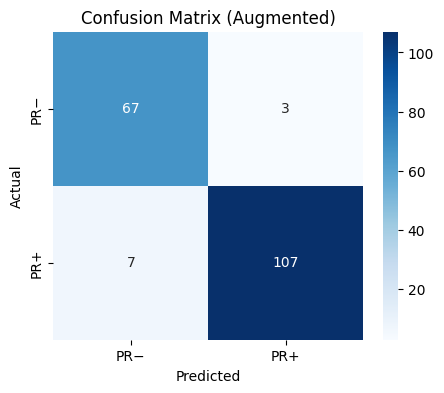

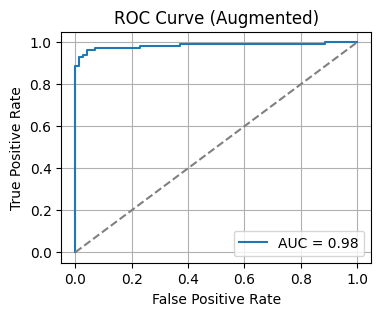

In [24]:
# Plot loss and accuracy
plt.figure(figsize=(5, 3))
plt.plot(aug_train_loss, label='Train Loss', color='red')
plt.plot(aug_train_acc, label='Train Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training on Real + Synthetic Data")
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# EVALUATE ON TEST SET
# ----------------------------
aug_model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = aug_model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("\nClassification Report (Augmented):\n", classification_report(y_true, y_pred, target_names=["PR−", "PR+"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["PR−", "PR+"], yticklabels=["PR−", "PR+"])
plt.title("Confusion Matrix (Augmented)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC-ROC
auc = roc_auc_score(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Augmented)")
plt.legend()
plt.grid()
plt.show()


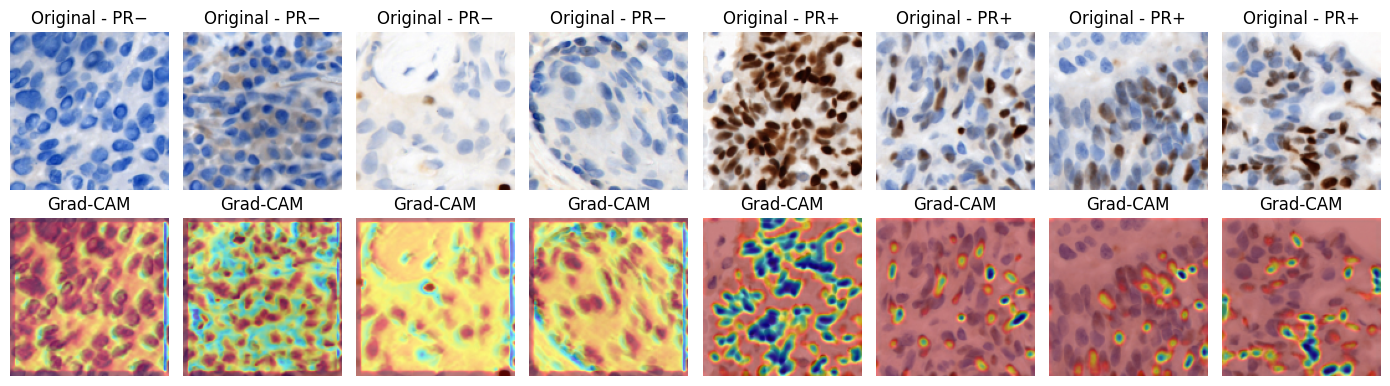

In [44]:
# ----------------------------
# Balanced sampling: up to 4 PR− and 4 PR+
# ----------------------------
selected_images = defaultdict(list)

for inputs, labels in test_loader:
    for img, lbl in zip(inputs, labels):
        if len(selected_images[lbl.item()]) < 4:
            selected_images[lbl.item()].append(img)
    if len(selected_images) == 2 and all(len(v) == 4 for v in selected_images.values()):
        break

# Merge samples and labels
all_images = []
all_labels = []
for label in selected_images:
    all_images.extend(selected_images[label])
    all_labels.extend([label] * len(selected_images[label]))

test_images = torch.stack(all_images).to(device)
test_labels = torch.tensor(all_labels).to(device)

# ----------------------------
# Grad-CAM visualization
# ----------------------------
n_samples = len(test_images)

plt.figure(figsize=(14, 4))
for i in range(n_samples):
    img_tensor = test_images[i].unsqueeze(0)
    cam = grad_cam.generate(img_tensor)

    img_np = test_images[i].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + img_np
    overlay = overlay / np.max(overlay)

    plt.subplot(2, n_samples, i + 1)
    plt.imshow(img_np)
    plt.title(f"Original - {'PR−' if test_labels[i] == 0 else 'PR+'}")
    plt.axis('off')

    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("gradcam_comparison.png", dpi=300)


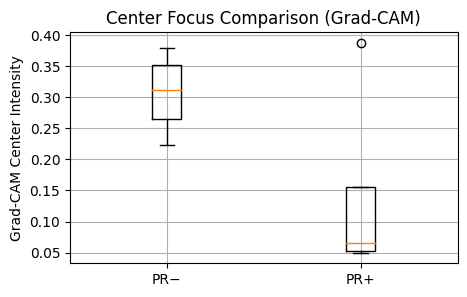

{'PR−_mean_center_focus': 0.3061583,
 'PR+_mean_center_focus': 0.14235972,
 'n_samples': 8}

In [45]:
import numpy as np

# ----------------------------
# GRAD-CAM METRIC: CENTER FOCUS INTENSITY
# ----------------------------

def gradcam_center_focus_score(grad_cam, center_fraction=0.5):
    """
    Computes the average Grad-CAM intensity in the center region of the heatmap.
    `center_fraction` defines how much of the heatmap's center to consider (e.g., 0.5 = central 50% square).
    """
    h, w = grad_cam.shape
    ch, cw = int(h * center_fraction), int(w * center_fraction)
    y1, y2 = (h - ch) // 2, (h + ch) // 2
    x1, x2 = (w - cw) // 2, (w + cw) // 2

    center_region = grad_cam[y1:y2, x1:x2]
    return center_region.mean()

# ----------------------------
# APPLY TO SAMPLE TEST IMAGES
# ----------------------------

center_focus_scores = []
classes = []

# Check 10 test samples for center focus Grad-CAM
for i in range(min(100, len(test_images))):
    img_tensor = test_images[i].unsqueeze(0)
    cam = grad_cam.generate(img_tensor)
    score = gradcam_center_focus_score(cam, center_fraction=0.5)
    center_focus_scores.append(score)
    classes.append(test_labels[i].item())

# Aggregate stats
focus_scores_pr_minus = [s for s, c in zip(center_focus_scores, classes) if c == 0]
focus_scores_pr_plus  = [s for s, c in zip(center_focus_scores, classes) if c == 1]

# Visualize
plt.figure(figsize=(5, 3))
plt.boxplot([focus_scores_pr_minus, focus_scores_pr_plus], labels=["PR−", "PR+"])
plt.ylabel("Grad-CAM Center Intensity")
plt.title("Center Focus Comparison (Grad-CAM)")
plt.grid()
plt.show()

# Mean focus scores
{
    "PR−_mean_center_focus": np.mean(focus_scores_pr_minus),
    "PR+_mean_center_focus": np.mean(focus_scores_pr_plus),
    "n_samples": len(center_focus_scores)
}
